<h1>Import libraries<h1>

In [1]:
from Model.XGBoost_Classifier_from_scratch import *
from Model.XGBoost_Regressor_from_scratch import *
from Model.XGBoost_optimization import *
from Metrics.Classification_metrics import *
from Metrics.Regression_metrics import *
from Plots.Prediction_plots import *
Plots_predictions = Prediction_plots()

<h1>Explanation of XGBoost<h1>

$\text{XGBoost is an algorithm that can be used for both regression and classification problems.}$<p>
$\text{In this case, boosting consists in determining subsequent predictions taking into account the errors of previous estimators.}$<p>
$\text{Compared to Gradient Boosting, XGBoost additionally adds regularization to help avoid overfitting.}$

<h2>Construction of XGBoost<h2>

$\text{The following scheme has been generalized to apply to both regression and classification problems.}$<p>
$\text{However, there are some differences between the two approaches.}$<p>
$\text{In the case of classification, there is an additional breakdown of the target variable using OneHotEncoding}$<p>
$\text{and making predictions separately for each class (similar to logistic regression).}$<p><br>
$1. \text{ Determining } T \text{ - the number of estimators.}$<p><br>
$2. \text{ Defining the initial prediction (detailed below for regression and classification):} $
$$Estimator_0\left(X\right)$$
$3. for \ t=1 \ to \ T:$<p>
$a) \text{ Construction of Extreme Tree as } Estimator_t.$<p>
$b) \text{ Train the estimator: } Estimator_t \text{ given the true values } y_i \text{ and the predictions of the preceding } Estimator_{t-1}\left(X\right).$<p>
$c) \text{ Make predictions: } O$<p>
$d) \text{ Update predictions of } Estimator_t:$
$${Estimator}_t\left(X\right)=Estimator_{t-1}\left(X_i\right)+learning\_rate\times O$$

<h2>Construction of Extreme Tree<h2>

$\text{The XGBoost algorithm is based on special trees (Extreme Trees), which make split decisions based on simmilarity and gain.}$<p>
$\text{The following formulas for classification and regression show how both measures are calculated.}$<p><br>
$\textbf{Determining the optimal value } O:$<p>
$\text{In order to find the optimal value in a leaf, we will use the following cost function:}$
$$\mathcal{L}=Loss\left(y_i,{\hat{y}}_i+O_i\right)+\gamma\times leaves+\frac{1}{2}\times\lambda\times{O_i}^2$$
$\text{Where: } {\hat{y}}_i \text{ – prediction determined by the predecessor for observation } i,$<p>
$O_i \text{ – output value, i.e. a new prediction for observation } i, \text{ which we will be optimizing,}$<p>
$\gamma \text{ - const., the parameter responsible for pruning (the higher the value, the less developed the tree, so the smaller the variance at the expense of a larger error),}$<p>
$leaves \text{ - number of leaves in the tree,}$<p>
$\lambda \text{ – const., L2 regularization parameter.}$<p>
$\text{Determining the optimal } O \text{ value for } Loss\left(y,\hat{y}+O\right) \text{ is possible using the Second Order Taylor Approximation:}$
$$Loss\left(y_i,{\hat{y}}_i+O_i\right)\approx L\left(y_i,{\hat{y}}_i\right)+\frac{\partial}{\partial{\hat{y}}_i}\left(L\left(y_i,{\hat{y}}_i\right)\right)\times O_i+\frac{1}{2}\times\frac{\partial^2}{\partial{{\hat{y}}_i}^2}\left(L\left(y_i,{\hat{y}}_i\right)\right)\times{O_i}^2$$
$\text{For XGBoost it is customary that:}$
$${gradient}_i=\frac{\partial}{\partial{\hat{y}}_i}\left(L\left(y_i,{\hat{y}}_i\right)\right)$$
$${hessian}_i=\frac{\partial^2}{\partial{{\hat{y}}_i}^2}\left(L\left(y_i,{\hat{y}}_i\right)\right)$$
$\text{Thus:}$
$$Loss\left(y_i,{\hat{y}}_i+O_i\right)\approx L\left(y_i,{\hat{y}}_i\right)+{gradient}_i\times O_i+\frac{1 }{2}\times{hessian}_i\times{O_i}^2$$
$\text{Plugging this into the original formula, we get:}$
$$\mathcal{L}=L\left(y_i,{\hat{y}}_i\right)+{gradient}_i\times O_i+\frac{1}{2}\times{hessian}_i\times{O_i} ^2+\gamma\times leaves+\frac{1}{2}\times\lambda\times{O_i}^2$$
$\text{So the derivative of the cost function over } O_i \text{ is:}$
$$\frac{\partial\mathcal{L}}{\partial O_i}={gradient}_i+\left({hessian}_i+\lambda\right)\times O_i=0$$
$$O_i=-\frac{{gradient}_i}{{hessian}_i+\lambda}$$

$\textbf{Simmilarities:}$<p><br>
$\text{Knowing what the cost function } \mathcal{L} \text{ looks like and the optimal values, we can determine the simmilarity score by removing the } O-\text{ independent components:}$
$$Simmilarity=-\left(gradient\times O+\frac{1}{2}\times(hessian+\lambda)\times O^2\right)=$$
$$=-\left(gradient\times\left(-\frac{gradient}{hessian+\lambda}\right)+\frac{1}{2}\times\left(hessian+\lambda\right)\times\left(-\frac{gradient}{hessian+\lambda}\right)^2\right)=$$
$$=-\left(-\frac{gradient^2}{hessian+\lambda}+\frac{1}{2}\times\frac{gradient^2}{hessian+\lambda}\right)=-\left(-\frac{1}{2}\times\frac{gradient^2}{hessian+\lambda}\right)=$$
$$=\frac{1}{2}\times\frac{gradient^2}{hessian+\lambda}$$

$\textbf{Gain:}$<p><br>
$\text{We will verify potential splits using gain:}$
$$Gain=Simmilarity\_left+Simmilarity\_right-Simmilarity\_root$$
$\text{If the Gain value is greater than the Gain from the previous split, the tree will be expanded.}$

$\textbf{Splitting nodes:}$<p><br>
$\text{Even before we start calculating similarity or gain, we should determine the values for which we will verify potential divisions.}$<p>
$\text{For large datasets, XGBoost uses a Weighted Quantile Sketch to speed up training time.}$<p>
$\text{Instead of going through each point, XGBoost uses Hessian and buckets for each variable to determine the split points.}$<p><br>
$1. \text{ For the variable } m \text{ (which we are currently considering), we create the set: }$
$$\left\{\left(x_{1,m},h_1\right),\ \left(x_{2,m},h_2\right),\ldots,\left(x_{N,m},h_N\right)\right\}$$
$\text{Where: } h_i \text{ - hessian for observation } i,$<p><br>
$2. \text{ We sort the set (in ascending order) by } X_m.$<p><br>
$3. \text{ We create ranks for each observation of variable } m:$
$$r_m\left(z\right)=\frac{\sum_{(x,h)\in D_m,\ x<z}{hessian_i}}{\sum_{(x,h)\in D_m}{hessian_i}}$$
$4. \text{ The ranks that will be selected must meet the following inequality:}$
$$\left|r_m\left(x_{m,\ j}\right)-r_m\left(x_{m,j+1}\right)\right|<\varepsilon$$
$\text{Where: } \varepsilon \text{ -const.}$<p><br>
$5. \text{ Then the interpolation value will be the "midpoint":}$
$$interpolation\_value=\frac{x_{m,\ j}+x_{m,j+1}}{2}$$
$\text{Notice then that the above algorithm not only takes into account the nominal difference between the values,}$<p>
$\text{but also assigns higher weights to the observations whose hessian (that is, the slope of the loss function) is higher.}$<p>
$\text{In addition, the above method guarantees us that if there are few values left in the node,}$<p>
$\text{no } interpolation\_value \text{ will probably be created (thus preventing overfitting).}$

<h2>Classification<h2>

$\textbf{Loss function:}$<p><br>
$$log\_loss=-\frac{1}{N}\times\sum_{i=1}^{N}{y_i\times\ln({\hat{p}}_i)+\left(1-y_i\right)\times\ln(1-{\hat{p}}_i)}$$
$\text{Where: } N \text{ - number of observations,}$<p>
$y_i \text{ – value of the dependent variable for observation } i,$<p>
${\hat{p}}_i \text{ – the probability of a class that is equivalent to } y_i.$<p>
$\text{However, to find the probability: } \hat{p}\ \text{ we first need to know the value of } \hat{y}.$<p>
$\text{With XGBoost, each prediction is equivalent to the log of "odds" - } log\_odds.$<p>
$\text{The conversion of } log\_odds \text{ into probability is given by the following formula:}$
$${\hat{p}}_i=\frac{1}{1+e^{-log\_odds}}=\frac{1}{1+e^{-{\hat{y}}_i}}$$
$\text{Same as for Gradient Boosting, we can write the loss functions as:}$
$$log{\_loss}=-\frac{1}{N}\times\sum_{i=1}^{N}\left(y_i\times\ln{\left({\hat{p}}_i\right)}+\ln{\left(1-{\hat{p}}_i\right)}-y_i\times\ln{\left(1-{\hat{p}}_i\right)}\right)=$$
$$=-\frac{1}{N}\times\sum_{i=1}^{N}\left(y_i\times{\hat{y}}_i-\ln{\left(1+e^{{\hat{y}}_i}\right)}\right)$$
$${gradient}_i=\frac{\partial}{\partial{\hat{y}}_i}\left(log\_loss\left(y_i,{\hat{y}}_i\right)\right)=$$
$${hessian}_i=\frac{\partial^2}{\partial{{\hat{y}}_i}^2}\left(log\_loss\left(y_i,{\hat{y}}_i\right)\right)=\frac{e^{-{\hat{y}}_i}}{\left(1+e^{-{\hat{y}}_i}\right)^2}=\frac{1}{1+e^{-{\hat{y}}_i}}\times\frac{1}{1+e^{{\hat{y}}_i}}$$
$\textbf{Initial value:}$<p><br>
$$Estimator_0\left(X\right)=-\ln{\left(\frac{N-\sum_{i\in k l a s a} y_i}{\sum_{i\in k l a s a} y_i}\right)}$$
$\textbf{Simmilarity:}$<p><br>
$\text{In total (in case many values went to the leaf):}$
$$Simmilarity=\frac{1}{2}\times\frac{gradient^2}{hessian+\lambda}=\frac{1}{2}\times\frac{\left(\sum_{i\in l e a f\_node}{-\left(y_i-\frac{1}{1+e^{-{\hat{y}}_i}}\right)}\right)^2}{\sum_{i\in l e a f\_node}\left(\frac{1}{1+e^{-{\hat{y}}_i}}\times\frac{1}{1+e^{{\hat{y}}_i}}\right)+\lambda}$$
$\textbf{Determing the optimal value } O:$<p><br>
$$O=-\frac{gradient}{hessian+\lambda}=-\frac{\sum_{i\in l e a f\_node}{-\left(y_i-\frac{1}{1+e^{-{\hat{y}}_i}}\right)}}{\sum_{i\in l e a f\_node}\left(\frac{1}{1+e^{-{\hat{y}}_i}}\times\frac{1}{1+e^{{\hat{y}}_i}}\right)+\lambda}=$$
$$=\frac{\sum_{i\in l e a f\_node}\left(y_i-\frac{1}{1+e^{-{\hat{y}}_i}}\right)}{\sum_{i\in l e a f\_node}\left(\frac{1}{1+e^{-{\hat{y}}_i}}\times\frac{1}{1+e^{{\hat{y}}_i}}\right)+\lambda}$$
$\text{Where: } N_{leaf\_node} \text{ – the number of observations that fell into a given leaf.}$

<h2>Important parameters<h2>

$\text{In the case of XGBoost, an important parameter is } min\_child\_weight, \text{ which is responsible for the minimum acceptable value that Cover must take, i.e. the denominator without } \lambda:$
$$Cover=\begin{cases}
               \sum_{i\in l e a f\_node}\left(\frac{1}{1+e^{-{\hat{y}}_i}}\times\frac{1}{1+e^{{\hat{y}}_i}}\right)\rightarrow Classification \\ 
                N_{leaf\_node}\rightarrow Regression
               \end{cases}$$
$\text{The split will take place if: }$
$$Cover\_left\geq min\_child\_weight\land Cover\_right\geq min\_child\_weight$$
$\text{While in the case of regression this will always be true because } N_{leaf\_node}\geq1, \text{ for classification this parameter prevents ovefitting by not allowing splits that slightly divide the data.}$<p><br>
$\text{The } \gamma \text{ parameter will be responsible for pruning the resulting branch if:}$
$$Gain<\gamma$$

<h1>Preprocessing<h1>

<h2>Download data<h2>

In [2]:
data = pd.read_csv("Data/bank-balanced.csv")
X = data.drop("deposit", axis=1)
y = data["deposit"]

In [3]:
print("Number of observations in data: {}".format(len(data)))
data.head()

Number of observations in data: 11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


<h2>Check for null data<h2>

In [4]:
data.isnull().sum()/len(data)

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
deposit      0.0
dtype: float64

<h2>Convert object to numeric<h2>

$\text{For XGBoost we have to convert object/string features to numeric.}$<p>
$\text{For XGBoost, the best option would be to use OridinalEncoding instead of OneHotEncoding because of that algorithm's problem with the curse of dimensionality}$

In [5]:
list_of_object_features_classification = data.select_dtypes(include="object").columns.tolist()
list_of_numeric_features_classification = data.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data[list_of_object_features_classification] = encoder.fit_transform(data[list_of_object_features_classification])

<h2>Divide our data into train and test sets<h2>

In [6]:
target_binary = "deposit"
X = data.drop(target_binary, axis=1)
y = data[[target_binary]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

$\text{The huge advantage of XGBoost compared to other popular algorithms is that there is no need to scale the data.}$

<h1>Modelling<h1>

$\text{To verify how well our algorithms are able to perform, a cross-validation will be used on the training set (in order to average the results obtained).}$<p>
$\text{Then we will check whether the algorithms will perform equally well (or even better) on the test data.}$

In [7]:
class Cross_Validation():
    def __init__(self, metric, algorithm_instance, cross_validation_instance):
        metrics = {"accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
                    "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
                    "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds"],
                    "rmse": [lambda y, y_pred: mean_squared_error(y, y_pred)**0.5, "preds"],
                    "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds"]}
        if metric not in metrics:
            raise ValueError('Unsupported metric: {}'.format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.algorithm = algorithm_instance
        self.cv = cross_validation_instance
    
    def fit(self, X, y, verbose=False):
        X = self.check_X(X=X)
        y = self.check_y(y=y)
        self.train_scores, self.valid_scores = [], []
        for iter, (train_idx, valid_idx) in enumerate(self.cv.split(X, y)):
            X_train, X_valid = X[train_idx, :], X[valid_idx, :]
            y_train, y_valid = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train, y_train)
            if(self.metric_type == "preds"):
                y_train_pred = self.algorithm.predict(X_train)
                y_valid_pred = self.algorithm.predict(X_valid)
            else:
                y_train_pred = self.algorithm.predict_proba(X_train)[:, 1]
                y_valid_pred = self.algorithm.predict_proba(X_valid)[:, 1]
            self.train_scores.append(self.eval_metric(y_train, y_train_pred))
            self.valid_scores.append(self.eval_metric(y_valid, y_valid_pred))
            if(verbose == True):
                print("Iter {}: train scores: {}; valid scores: {}".format(iter, np.round(self.eval_metric(y_train, y_train_pred), 5), np.round(self.eval_metric(y_valid, y_valid_pred), 5)))
        return np.mean(self.train_scores), np.mean(self.valid_scores)
    
    def check_X(self, X):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, np.ndarray) and not torch.is_tensor(X):
            raise TypeError('Wrong type of X. It should be dataframe, numpy array or torch tensor.')
        X = np.array(X)
        if(X.ndim == 1):
            X = X[None, :]
        return X
    
    def check_y(self, y):
        if not isinstance(y, pd.DataFrame) and not isinstance(y, pd.Series) and not isinstance(y, np.ndarray) and not torch.is_tensor(y):
            raise TypeError('Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        y = np.array(y)
        if(y.ndim == 2):
            y = y.squeeze()
        return y

In [8]:
model = XGBoost_Classifier(n_estimators=50, learning_rate=0.5, reg_lambda=1, gamma=0, max_depth=3, colsample_bytree=1.0, subsample=1, min_child_weight=1, random_state=17)
CV = Cross_Validation(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=True)
print("Mean of train scores: {}; Mean of valid scores: {}".format(np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Iter 0: train scores: 0.93618; valid scores: 0.92059
Iter 1: train scores: 0.93667; valid scores: 0.91982
Iter 2: train scores: 0.93534; valid scores: 0.92063
Iter 3: train scores: 0.93765; valid scores: 0.90934
Iter 4: train scores: 0.93429; valid scores: 0.92204
Mean of train scores: 0.93603; Mean of valid scores: 0.91848


$\text{As we can see our algorithm performs quite well on training and validation dataset.}$

$\text{Check the results for original test dataset.}$

In [9]:
model = XGBoost_Classifier(n_estimators=50, learning_rate=0.5, reg_lambda=1, gamma=0, max_depth=3, colsample_bytree=1.0, subsample=1, min_child_weight=1, random_state=17)
model.fit(X_train, y_train)
y_prob_train = model.predict_proba(X_train)[:,1]
y_prob_test = model.predict_proba(X_test)[:,1]
print("XGBoost Classifier: Train: {}; Test: {}".format(np.round(roc_auc_score(y_train, y_prob_train), 4), np.round(roc_auc_score(y_test, y_prob_test), 4)))

XGBoost Classifier: Train: 0.9335; Test: 0.9206


$\text{Write down predictions for the future}$

In [10]:
base_predictions = model.predict(X_test)
base_probabilities = model.predict_proba(X_test)[:, 1]

$\text{We will try to tune hyperparameters to see whether we can improve accuracy.}$<p>
$\text{To perform optimization we will use original XGBoost just because of faster compilation time.}$

<h1>Optimization<h1>

$\text{Let's start tuning with } n\_estimators \text{ parameter.}$<p>
$n\_estimators \ [int] \text{: specifying the number of trees used in building the forest.}$<p>
$\text{A larger number of trees reduces the likelihood of overfitting (better averaging/more models considered for voting)}$<p>
$\text{On the other hand, larger number of trees leads to more models to train, i.e. longer compilation time.}$<p>
$\text{As a rule, a value of 100 should be sufficient, but an optimal value can be found through cross-validation.}$

In [11]:
model = XGBClassifier(random_state=17, n_jobs=-1)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for n_estimators in range(10, 200, 20):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, n_estimators=n_estimators)
    print("n_estimators: {}; Mean of train scores: {}; Mean of valid scores: {}".format(n_estimators, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

n_estimators: 10; Mean of train scores: 0.94194; Mean of valid scores: 0.91064
n_estimators: 30; Mean of train scores: 0.97237; Mean of valid scores: 0.92019
n_estimators: 50; Mean of train scores: 0.98483; Mean of valid scores: 0.91982
n_estimators: 70; Mean of train scores: 0.99169; Mean of valid scores: 0.92023
n_estimators: 90; Mean of train scores: 0.9954; Mean of valid scores: 0.92033
n_estimators: 110; Mean of train scores: 0.99763; Mean of valid scores: 0.91984
n_estimators: 130; Mean of train scores: 0.99879; Mean of valid scores: 0.91946
n_estimators: 150; Mean of train scores: 0.99938; Mean of valid scores: 0.91903
n_estimators: 170; Mean of train scores: 0.9997; Mean of valid scores: 0.91913
n_estimators: 190; Mean of train scores: 0.99986; Mean of valid scores: 0.91941


$\text{We see that as we increase the number of estimators in the Gradient Boosting, our algorithm gets better results.}$<p>
$\text{However, from the level of } n\_estimators \approx 80 \text{ we can see a exacerbation, for this reason value of 80 will be used in further optimization.}$

$learning\_rate \ [float]: \text{ controls the loss function used for calculating the weight of the estimators.}$

In [12]:
model = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for learning_rate in np.linspace(0.01, 0.5, 15):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, learning_rate=learning_rate)
    print("learning_rate: {}; Mean of train scores: {}; Mean of valid scores: {}".format(learning_rate, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

learning_rate: 0.01; Mean of train scores: 0.9199; Mean of valid scores: 0.8972
learning_rate: 0.045; Mean of train scores: 0.94939; Mean of valid scores: 0.91409
learning_rate: 0.07999999999999999; Mean of train scores: 0.96556; Mean of valid scores: 0.91985
learning_rate: 0.11499999999999998; Mean of train scores: 0.9746; Mean of valid scores: 0.9213
learning_rate: 0.15; Mean of train scores: 0.98061; Mean of valid scores: 0.92159
learning_rate: 0.185; Mean of train scores: 0.9844; Mean of valid scores: 0.92131
learning_rate: 0.21999999999999997; Mean of train scores: 0.98832; Mean of valid scores: 0.92026
learning_rate: 0.25499999999999995; Mean of train scores: 0.99127; Mean of valid scores: 0.92014
learning_rate: 0.29; Mean of train scores: 0.993; Mean of valid scores: 0.92026
learning_rate: 0.32499999999999996; Mean of train scores: 0.99489; Mean of valid scores: 0.9198
learning_rate: 0.36; Mean of train scores: 0.99665; Mean of valid scores: 0.91862
learning_rate: 0.394999999999

$\text{Best results are obtained for } learning\_rate \approx 0.15$

$\lambda \ [float]: \text{L2 regularization.}$<p>
$\text{Higher values should lead to smaller trees due to decreasment in Simmilarity, and therefore in Gain.}$

In [13]:
model = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80, learning_rate=0.15)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for reg_lambda in np.linspace(0.1, 10, 15):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, reg_lambda=reg_lambda)
    print("reg_lambda: {}; Mean of train scores: {}; Mean of valid scores: {}".format(reg_lambda, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

reg_lambda: 0.1; Mean of train scores: 0.98413; Mean of valid scores: 0.92157
reg_lambda: 0.8071428571428572; Mean of train scores: 0.98169; Mean of valid scores: 0.9225
reg_lambda: 1.5142857142857145; Mean of train scores: 0.97817; Mean of valid scores: 0.92107
reg_lambda: 2.2214285714285715; Mean of train scores: 0.97637; Mean of valid scores: 0.92312
reg_lambda: 2.928571428571429; Mean of train scores: 0.97535; Mean of valid scores: 0.92312
reg_lambda: 3.635714285714286; Mean of train scores: 0.97415; Mean of valid scores: 0.92209
reg_lambda: 4.3428571428571425; Mean of train scores: 0.97263; Mean of valid scores: 0.92349
reg_lambda: 5.05; Mean of train scores: 0.97111; Mean of valid scores: 0.92262
reg_lambda: 5.757142857142857; Mean of train scores: 0.971; Mean of valid scores: 0.92352
reg_lambda: 6.464285714285714; Mean of train scores: 0.96936; Mean of valid scores: 0.92305
reg_lambda: 7.171428571428572; Mean of train scores: 0.96864; Mean of valid scores: 0.9238
reg_lambda: 7.8

$\text{Best valid scores are obtained for } \lambda \approx 7.2$

$\gamma \ [float]: \text{ specifies the minimum Gain to make a split.}$<p>
$\text{Higher values should lead to smaller trees and more conservative algorithm.}$

In [14]:
model = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80, learning_rate=0.15, reg_lambda=7.2)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for gamma in np.linspace(0.1, 3, 15):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, gamma=gamma)
    print("gamma: {}; Mean of train scores: {}; Mean of valid scores: {}".format(gamma, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

gamma: 0.1; Mean of train scores: 0.96861; Mean of valid scores: 0.92345
gamma: 0.30714285714285716; Mean of train scores: 0.96962; Mean of valid scores: 0.92345
gamma: 0.5142857142857142; Mean of train scores: 0.96848; Mean of valid scores: 0.92305
gamma: 0.7214285714285714; Mean of train scores: 0.96779; Mean of valid scores: 0.92315
gamma: 0.9285714285714285; Mean of train scores: 0.96778; Mean of valid scores: 0.92269
gamma: 1.1357142857142857; Mean of train scores: 0.96717; Mean of valid scores: 0.92399
gamma: 1.342857142857143; Mean of train scores: 0.96562; Mean of valid scores: 0.92461
gamma: 1.55; Mean of train scores: 0.96479; Mean of valid scores: 0.92368
gamma: 1.7571428571428571; Mean of train scores: 0.9629; Mean of valid scores: 0.924
gamma: 1.9642857142857142; Mean of train scores: 0.96131; Mean of valid scores: 0.92323
gamma: 2.1714285714285713; Mean of train scores: 0.95921; Mean of valid scores: 0.92483
gamma: 2.3785714285714286; Mean of train scores: 0.95783; Mean o

$\text{Best valid scores are obtained for } \gamma \approx 2.18$

$max\_depth \ [int]: \text{ is used to control the depth of the tree (its downward expansion).}$<p>
$\text{The greater the depth of the tree, the greater the likelihood of overfitting.}$<p>
$\text{On the other hand, too low depth can lead to underfitting.}$

In [15]:
model = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80, learning_rate=0.15, reg_lambda=7.2, gamma=2.18)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for max_depth in range(2, 10, 1):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, max_depth=max_depth)
    print("max_depth: {}; Mean of train scores: {}; Mean of valid scores: {}".format(max_depth, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

max_depth: 2; Mean of train scores: 0.91359; Mean of valid scores: 0.90465
max_depth: 3; Mean of train scores: 0.92996; Mean of valid scores: 0.91477
max_depth: 4; Mean of train scores: 0.94185; Mean of valid scores: 0.91968
max_depth: 5; Mean of train scores: 0.9518; Mean of valid scores: 0.9221
max_depth: 6; Mean of train scores: 0.96003; Mean of valid scores: 0.92503
max_depth: 7; Mean of train scores: 0.96548; Mean of valid scores: 0.92393
max_depth: 8; Mean of train scores: 0.96694; Mean of valid scores: 0.92367
max_depth: 9; Mean of train scores: 0.97487; Mean of valid scores: 0.92367


$\text{The biggest valid score was obtained for } max\_depth=6$

$colsample\_bytree \ [float]: \text{ the ratio of features when constructing each tree.}$<p>
$\text{It is simmilar to } max\_features \text{ parameter in RandomForest.}$<p>
$\text{The fewer variables to check, the shorter the compilation.}$<p>
$\text{On the other hand, probability increases that we will not choose the most optimal variable at a given node,}$<p>
$\text{which can reduce the effectiveness of the algorithm.}$

In [16]:
model = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80, learning_rate=0.15, reg_lambda=7.2, gamma=2.18, max_depth=6)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for colsample_bytree in np.linspace(0.5, 1, 10):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, colsample_bytree=colsample_bytree)
    print("colsample_bytree: {}; Mean of train scores: {}; Mean of valid scores: {}".format(colsample_bytree, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

colsample_bytree: 0.5; Mean of train scores: 0.95438; Mean of valid scores: 0.92245
colsample_bytree: 0.5555555555555556; Mean of train scores: 0.95438; Mean of valid scores: 0.92245
colsample_bytree: 0.6111111111111112; Mean of train scores: 0.95634; Mean of valid scores: 0.92246
colsample_bytree: 0.6666666666666666; Mean of train scores: 0.95748; Mean of valid scores: 0.92368
colsample_bytree: 0.7222222222222222; Mean of train scores: 0.95763; Mean of valid scores: 0.92358
colsample_bytree: 0.7777777777777778; Mean of train scores: 0.9574; Mean of valid scores: 0.92355
colsample_bytree: 0.8333333333333333; Mean of train scores: 0.95873; Mean of valid scores: 0.92372
colsample_bytree: 0.8888888888888888; Mean of train scores: 0.95897; Mean of valid scores: 0.92362
colsample_bytree: 0.9444444444444444; Mean of train scores: 0.959; Mean of valid scores: 0.9241
colsample_bytree: 1.0; Mean of train scores: 0.96003; Mean of valid scores: 0.92503


$\text{The biggest valid score was obtained for } colsample\_bytree=1$

$subsample \ [float]: \text{ fraction of samples to be used for fitting the individual estimator.}$<p>
$subsample=1 \text{ means that we are taking all samples into account while fitting estimator.}$<p>
$subsample<1 \text{ leads to a reduction of variance, but increase in bias.}$<p>
$\text{This parameter is kinda simmilar to bootstrap in Random Forest.}$<p>
$\text{However, subsample limits the number of samples, i.e. we will only train } sumbsample*N \text{ training samples.}$<p>
$\text{On the other hand, bootstrap makes us take copies of some observations, while there are still } N \text{ samples.}$

In [17]:
model = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80, learning_rate=0.15, reg_lambda=7.2, gamma=2.18, max_depth=6, colsample_bytree=1)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for subsample in np.linspace(0.4, 1.0, 10):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, subsample=subsample)
    print("subsample: {}; Mean of train scores: {}; Mean of valid scores: {}".format(subsample, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

subsample: 0.4; Mean of train scores: 0.95196; Mean of valid scores: 0.91994
subsample: 0.4666666666666667; Mean of train scores: 0.95437; Mean of valid scores: 0.92046
subsample: 0.5333333333333333; Mean of train scores: 0.95689; Mean of valid scores: 0.92116
subsample: 0.6000000000000001; Mean of train scores: 0.95867; Mean of valid scores: 0.9217
subsample: 0.6666666666666667; Mean of train scores: 0.95957; Mean of valid scores: 0.92268
subsample: 0.7333333333333334; Mean of train scores: 0.96094; Mean of valid scores: 0.9235
subsample: 0.8; Mean of train scores: 0.96199; Mean of valid scores: 0.92412
subsample: 0.8666666666666667; Mean of train scores: 0.96211; Mean of valid scores: 0.92327
subsample: 0.9333333333333333; Mean of train scores: 0.96215; Mean of valid scores: 0.92361
subsample: 1.0; Mean of train scores: 0.96003; Mean of valid scores: 0.92503


$\text{The biggest valid score was obtained for } subsample=1$

$ min\_child\_weight \ [float]: \text{the minimum sum of weights (hessian) of all observations in child node.}$<p>
$\text{Split will take place if: } Cover\_left\geq min\_child\_weight\land Cover\_right\geq min\_child\_weight$<p>
$\text{Thus, the higher the value the model is more conservative.}$

In [18]:
model = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80, learning_rate=0.15, reg_lambda=7.2, gamma=2.18, max_depth=6, colsample_bytree=1, subsample=1)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for min_child_weight in np.linspace(1, 3, 10):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, min_child_weight=min_child_weight)
    print("min_child_weight: {}; Mean of train scores: {}; Mean of valid scores: {}".format(min_child_weight, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

min_child_weight: 1.0; Mean of train scores: 0.96003; Mean of valid scores: 0.92503
min_child_weight: 1.2222222222222223; Mean of train scores: 0.9605; Mean of valid scores: 0.92448
min_child_weight: 1.4444444444444444; Mean of train scores: 0.95859; Mean of valid scores: 0.92371
min_child_weight: 1.6666666666666665; Mean of train scores: 0.96004; Mean of valid scores: 0.92331
min_child_weight: 1.8888888888888888; Mean of train scores: 0.9597; Mean of valid scores: 0.92401
min_child_weight: 2.111111111111111; Mean of train scores: 0.9592; Mean of valid scores: 0.92363
min_child_weight: 2.333333333333333; Mean of train scores: 0.95682; Mean of valid scores: 0.92354
min_child_weight: 2.5555555555555554; Mean of train scores: 0.95839; Mean of valid scores: 0.92341
min_child_weight: 2.7777777777777777; Mean of train scores: 0.9592; Mean of valid scores: 0.92395
min_child_weight: 3.0; Mean of train scores: 0.95713; Mean of valid scores: 0.92324


$\text{The biggest valid score was obtained for } min\_child\_weight=1$

$scale\_pos\_weight \ [float]: \text{ control the frequency of each class in the dataset.}$<p>
$\text{It should be ratio of: } \frac{number\_of\_negative\_classes}{number\_of\_positive\_classes}$<p>
$\text{Simmilar to } class\_weight \text{ parameter in RandomForest.}$

In [19]:
model = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80, learning_rate=0.15, reg_lambda=7.2, gamma=2.18, max_depth=6, colsample_bytree=1, subsample=1, min_child_weight=1)
CV = Cross_Validation_XGB_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
scale_pos_weight_list = list(np.linspace(1, 2, 5))
scale_pos_weight_list.append(y_train.value_counts()[0]/y_train.value_counts()[1])
for scale_pos_weight in scale_pos_weight_list:
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, scale_pos_weight=scale_pos_weight)
    print("scale_pos_weight: {}; Mean of train scores: {}; Mean of valid scores: {}".format(scale_pos_weight, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

scale_pos_weight: 1.0; Mean of train scores: 0.96003; Mean of valid scores: 0.92503
scale_pos_weight: 1.25; Mean of train scores: 0.96285; Mean of valid scores: 0.92411
scale_pos_weight: 1.5; Mean of train scores: 0.96357; Mean of valid scores: 0.92433
scale_pos_weight: 1.75; Mean of train scores: 0.96444; Mean of valid scores: 0.92355
scale_pos_weight: 2.0; Mean of train scores: 0.96327; Mean of valid scores: 0.92348
scale_pos_weight: 1.1193923569902682; Mean of train scores: 0.96067; Mean of valid scores: 0.92335


$\text{The biggest valid score was obtained for } scale\_pos\_weight=1$

<h1>Evaluation and Visualization<h1>

In [20]:
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=base_predictions), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=base_probabilities), 5)))
report = classification_report(y_test, base_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.85673
Roc AUC score: 0.9206
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.866142 | 0.855661 |   0.86087  | 1157        |
| 1.0          |    0.846789 | 0.857807 |   0.852262 | 1076        |
| accuracy     |    0.856695 | 0.856695 |   0.856695 |    0.856695 |
| macro avg    |    0.856465 | 0.856734 |   0.856566 | 2233        |
| weighted avg |    0.856816 | 0.856695 |   0.856722 | 2233        |
+--------------+-------------+----------+------------+-------------+


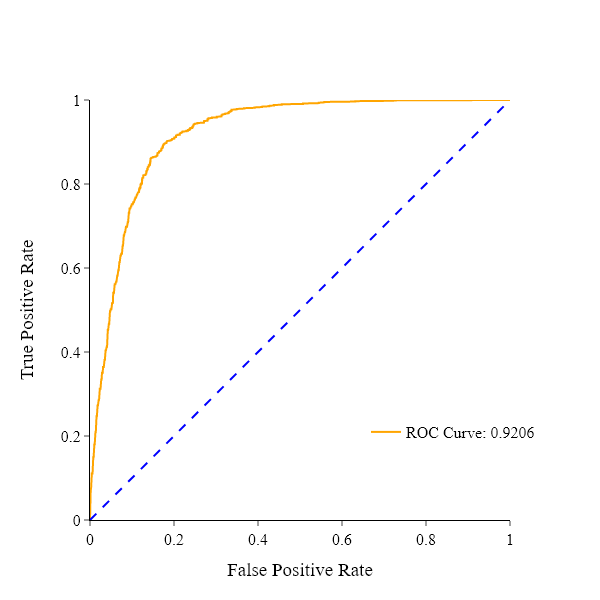

In [21]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=base_probabilities)

$\text{Final estimator: } n\_estimators=80, \ learning\_rate=0.15, \ reg\_lambda=7.2, \ gamma=2.18, \ max\_depth=6, \ colsample\_bytree=1, \ subsample=1, \ min\_child\_weight=1, \ scale\_pos\_weight=1$

In [22]:
final_algorithm_optimized = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=80, learning_rate=0.15, reg_lambda=7.2, gamma=2.18, max_depth=6, colsample_bytree=1, subsample=1, min_child_weight=1, scale_pos_weight=1)
final_algorithm_optimized.fit(X_train, np.array(y_train).squeeze())
y_pred_final_optimized = final_algorithm_optimized.predict(X_test)
y_prob_final_optimized = final_algorithm_optimized.predict_proba(X_test)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_final_optimized), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=y_prob_final_optimized), 5)))
report = classification_report(y_test, y_pred_final_optimized, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.86427
Roc AUC score: 0.9301
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| 0.0          |    0.880464 | 0.853068 |   0.86655  | 1157       |
| 1.0          |    0.847122 | 0.875465 |   0.86106  | 1076       |
| accuracy     |    0.86386  | 0.86386  |   0.86386  |    0.86386 |
| macro avg    |    0.863793 | 0.864266 |   0.863805 | 2233       |
| weighted avg |    0.864398 | 0.86386  |   0.863905 | 2233       |
+--------------+-------------+----------+------------+------------+


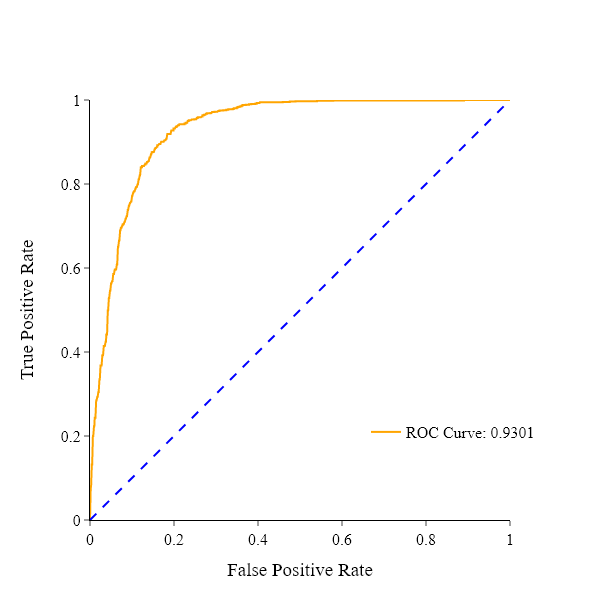

In [23]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=y_prob_final_optimized)

$\text{As we can see hyperparameter tuning have improved the effectiveness of the XGBoost!}$

<h2>XGBoost Regressor<h2>

$\textbf{Loss function:}$<p><br>
$\text{The default loss function for XGBoost is } squared\_error:$
$$squared\_error\left(y_i,{\hat{y}}_i\right)=\left(y_i-{\hat{y}}_i\right)^2$$
$${gradient}_i=\frac{\partial}{\partial{\hat{y}}_i}\left(squared\_error\left(y_i,{\hat{y}}_i\right)\right)=-2\times\left(y_i-\widehat{y_i}\right)$$
$${hessian}_i=\frac{\partial^2}{\partial{\hat{y}}_i}\left(squared\_error\left(y_i,{\hat{y}}_i\right)\right)=2$$
$\textbf{Initial value:}$<p><br>
$\text{For regression base prediction is initialized to } 0.5:$
$$Estimator_0\left(X\right)=0.5$$
$\textbf{Simmilarity:}$<p><br>
$\text{Totally (in case multiple values end up in a leaf):}$
$$Simmilarity=\frac{1}{2}\times\frac{gradient^2}{hessian+\lambda}=\frac{1}{2}\times\frac{\left(-2\times\sum_{i\in l e a f\_node}\left(y_i-{\hat{y}}_i\right)\right)^2}{2\times N_{leaf\_node}+\lambda}$$
$\text{Remember that } {\hat{y}}_i \text{ – prediction from the previous estimator, which is in fact } Estimator_{t-1}\left(X_i\right).$<p>
$\textbf{Determing the optimal value } O:$
$$O=-\frac{gradient}{hessian+\lambda}=-\frac{\sum_{i\in l e a f\_node}{-\left(y_i-\frac{1}{1+e^{-{\hat{y}}_i}}\right)}}{\sum_{i\in l e a f\_node}\left(\frac{1}{1+e^{-{\hat{y}}_i}}\times\frac{1}{1+e^{{\hat{y}}_i}}\right)+\lambda}=$$
$$=\frac{\sum_{i\in l e a f\_node}\left(y_i-\frac{1}{1+e^{-{\hat{y}}_i}}\right)}{\sum_{i\in l e a f\_node}\left(\frac{1}{1+e^{-{\hat{y}}_i}}\times\frac{1}{1+e^{{\hat{y}}_i}}\right)+\lambda}$$
$\text{Where: } N_{leaf\_node} \text{– the number of observations that fell into a given leaf.}$

<h2>Download data<h2>

In [24]:
data = pd.read_csv("Data/Sales.csv")
X = data.drop("Sales", axis=1)
y = data["Sales"]

In [25]:
print("Number of observations in data: {}".format(len(data)))
data.head()

Number of observations in data: 4572


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


<h2>Check for null data<h2>

In [26]:
data.isnull().sum()/len(data)

TV              0.002187
Radio           0.000875
Social Media    0.001312
Influencer      0.000000
Sales           0.001312
dtype: float64

In [27]:
data.dropna(inplace=True)

<h2>Convert object to numeric<h2>

In [28]:
list_of_object_features = data.select_dtypes(include="object").columns.tolist()
list_of_numeric_features = data.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data[list_of_object_features] = encoder.fit_transform(data[list_of_object_features])

<h2>Divide our data into train and test sets<h2>

In [29]:
target_binary = "Sales"
X = data.drop(target_binary, axis=1)
y = data[[target_binary]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

<h1>Evaluation and Visualization<h1>

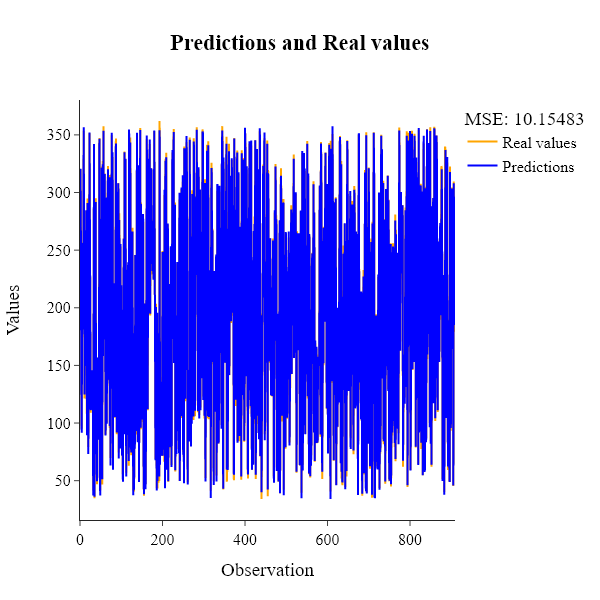

In [30]:
model = XGBoost_Regressor(n_estimators=100, learning_rate=0.3, random_state=17)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Plots_predictions.compare_predictions_with_real_values(y_true=y_test, y_pred=y_pred, metric="MSE")

<h2>Features importance<h2>

$\text{As with the random forest, the significance of the variables will be based on the estimators from which Ensemble was built.}$<p>
$$feature\_importnace_m=\frac{\sum_{t\in n u m b e r\ of\ trees}{feature\_importnace}_{m,t}}{number\ of\ trees}$$

$\text{Where: number of trees - the number of all trees in the forest,}$<p>
${feature\_importnace}_{m,t} \text{ - the importance of variable } m \text{ for tree } t.$

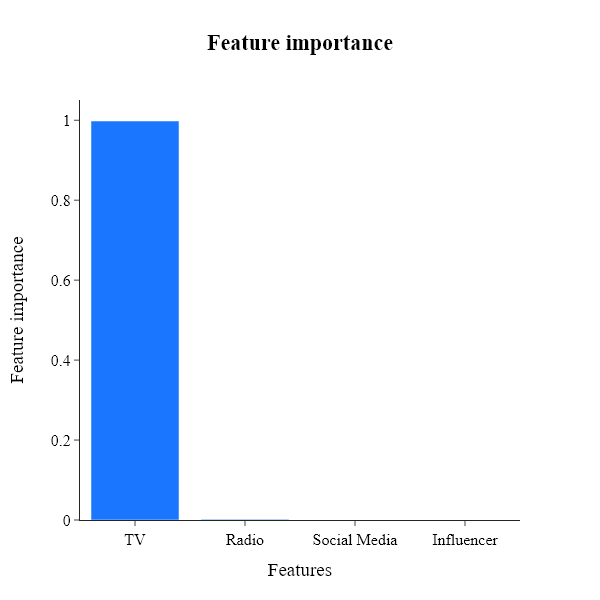

In [31]:
Plots_predictions.plot_feature_importances(feature_importances=list(model.normalized_feature_importances.values()), column_names=X.columns.tolist())